a) Python-Routine um lars seine .npy-Dateien als Diagramm darzustellen

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.fft import fft, fftfreq

folders = ["hoch", "links", "rechts", "tief"]

#44.100 Abtastvorgänge pro Sekunde
def cut_signal(data, threshold=0.01, fs=44100):
    start_index = 0
    for i, sample in enumerate(data):
        if abs(sample) > threshold:
            start_index = i
            break
    end_index = start_index + fs
    cut_data = data[start_index:end_index]
    if len(cut_data) < fs:
        cut_data = np.append(cut_data, [0]*(fs - len(cut_data)))
    return cut_data

for folder in folders:
    files = [file for file in os.listdir(f"lars/{folder}") if file.endswith(".npy")]
    n = len(files)
    fig, axs = plt.subplots(n, 2, figsize=(10, n*2))
    fs = 44100

    for i, file in enumerate(files):
        data = np.load(f"lars/{folder}/" + file)
        triggered_data = cut_signal(data)

        # Plot original data
        axs[i, 0].plot(data)
        axs[i, 0].set_title(f"Original data: {folder}: {file}")
        axs[i, 0].set_xlabel('Sample')
        axs[i, 0].set_ylabel('Amplitude')

        # Plot triggered data
        axs[i, 1].plot(triggered_data)
        axs[i, 1].set_title(f"Triggered data: {folder}: {file}")
        axs[i, 1].set_xlabel('Sample')
        axs[i, 1].set_ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

c) Bestimmung des Amplitudenspektrums
Stelle dieses Amplitudenspektrum graphisch dar.

In [ ]:
# Apply the function to the data
for folder in folders:
    files = [file for file in os.listdir(f"lars/{folder}") if file.endswith(".npy")]

    # Create a grid of 1 column and enough rows to hold all plots
    n = len(files)
    fig, axs = plt.subplots(n, 1, figsize=(10, n*2))
    fs = 44100

    for i, file in enumerate(files):
        data = np.load(f"lars/{folder}/" + file)
        triggered_data = cut_signal(data)

        # Compute the amplitude spectrum
        N = len(triggered_data)
        yf = fft(triggered_data)
        xf = fftfreq(N, 1 / 44100)

        axs[i].plot(xf, np.abs(yf))
        axs[i].set_title(f"{folder}: {file}")
        axs[i].set_xlabel('Frequenz (Hz)')  # Set x-axis label
        axs[i].set_ylabel('Amplitude')  # Set y-axis label

    plt.tight_layout()
    plt.show()

d) Implementierung des Windowing-Verfahrens

ValueError: x and y must have same first dimension, but have shapes (44100,) and (512,)

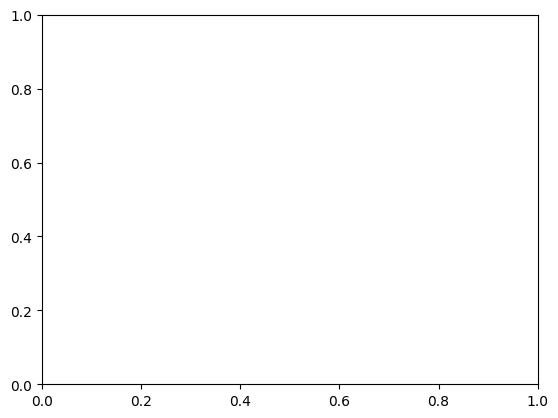

In [92]:
from scipy.signal.windows import gaussian

#Noch nicht das Ergebnis das wir wollen glaub
def apply_gaussian_window(data, section_size=512):
    sections = []
    ffts = []
    for i in range(0, len(data), section_size // 2):
        section = data[i:i+section_size]

        # Zero-pad the section to the fixed length
        if len(section) < section_size:
            section = np.pad(section, (0, section_size - len(section)))

        # Create the Gaussian window to match the size of the section
        window = gaussian(len(section), std=section_size/4)

        # Apply the window to the section
        windowed_section = section * window

        # Apply FFT to the windowed section
        fft_section = fft(windowed_section)

        sections.append(windowed_section)
        ffts.append(fft_section)

    # Compute the average of the FFTs
    avg_fft = np.mean(ffts, axis=0)

    # Compute the amplitude spectrum
    N = len(amplitude_spectrum)
    xf = fftfreq(N, 1 / 44100)

    return sections, ffts, amplitude_spectrum

sections, ffts, amplitude_spectrum = apply_gaussian_window(triggered_data)

# Plot the amplitude spectrum
plt.plot(xf, amplitude_spectrum)
plt.title(f"{folder}: {file}")
plt.xlabel('Frequenz (Hz)')  # Set x-axis label
plt.ylabel('Amplitude')  # Set y-axis label
plt.show()


